In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import model_predict

# 指定支持中文的字体，例如SimHei或者Microsoft YaHei
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [6]:
series, scaler = model_predict.read_data_series(scale=False), None
features, targets = model_predict.gen_xgboost_data(series)

时间序列连贯


In [7]:
# 划分训练集和测试集  
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=12/len(features), shuffle=False)
# X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)

In [11]:
# 创建XGBoost模型  
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.07, gamma=0, subsample=0.75,  
                         colsample_bytree=1, max_depth=7)
  
# 训练模型  
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

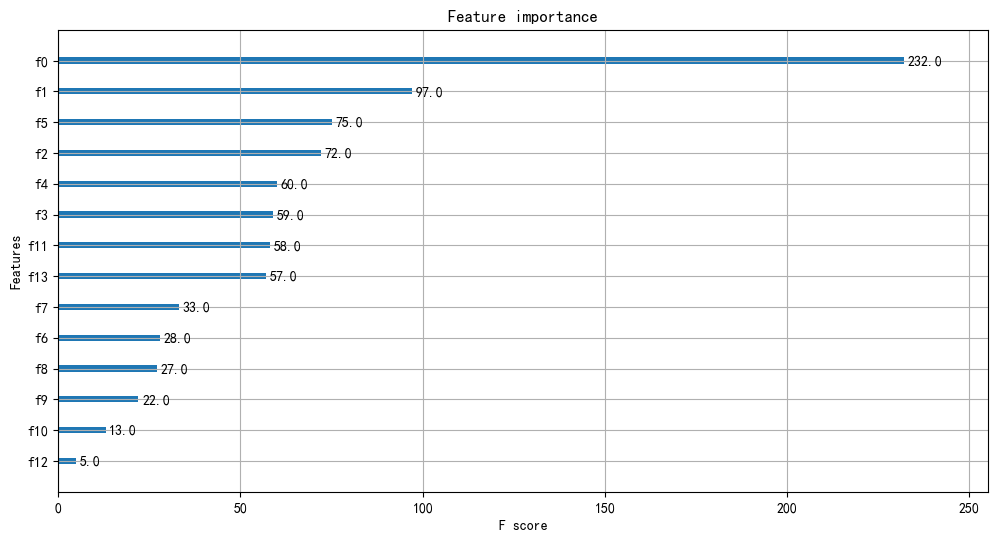

MSE: 966.09
MAE: 21.98
R^2: 0.16
MAPE: 0.39


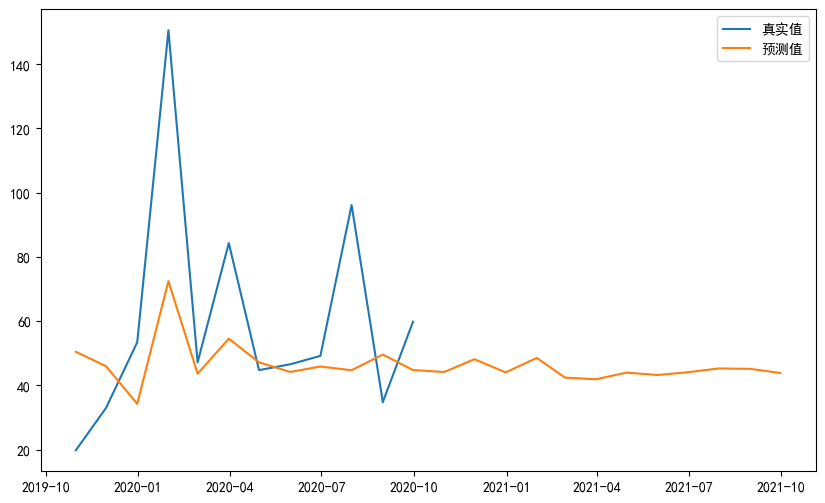

In [12]:
from importlib import reload
reload(model_predict)
model_predict.predict_to_future_xgboost(model, series, scaler)

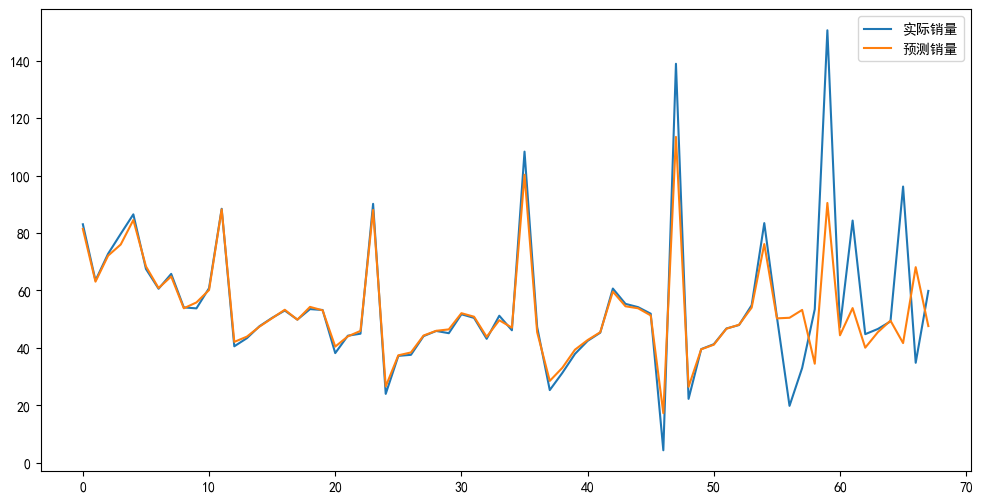

In [13]:
# 预测和评估  
y_pred = model.predict(features)  
if scaler != None:
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
    targets_inv = scaler.inverse_transform(targets.reshape(-1, 1)).reshape(-1)
else:
    targets_inv = targets
    y_pred_inv = y_pred

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(targets_inv, label='实际销量')
plt.plot(y_pred_inv, label='预测销量')
plt.legend()
plt.show()